In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from src.towers.query import QueryTower
from src.towers.candidate import CandidateTower
from src.retrieval import RetrievalModel

from src.utils.utilities import (
    dataframe_to_Dataset,
    train_test_split,
    plot_history,
)

2024-08-28 19:31:39.890935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 19:31:39.906230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 19:31:39.910521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 19:31:39.922783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 19:31:40.981916: W tensorflow/compiler/tf2

In [3]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

In [4]:
# Ratings
ratings_df = pd.read_parquet('data/100k-ratings.parquet')
ratings_columns = [
    'bucketized_user_age',
    # 'movie_genres',
    'movie_id',
    'movie_title',
    'raw_user_age',
    'timestamp',
    'user_gender',
    'user_id',
    'user_occupation_label',
    'user_occupation_text',
    'user_rating',
    'user_zip_code'
]
ratings_dataset = dataframe_to_Dataset(ratings_df, ratings_columns)

I0000 00:00:1724860902.570568  290703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860902.602683  290703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860902.602749  290703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860902.606851  290703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860902.606959  290703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
# Ratings
movies_df = pd.read_parquet('data/100k-movies.parquet')
movies_columns = [
    # 'movie_genres',
    'movie_id',
    'movie_title'
]
movies_dataset = dataframe_to_Dataset(movies_df, movies_columns)

In [6]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

### Dataset Splitting

In [7]:
# Train and validation splits
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.0001,
    random_state = RANDOM_STATE,
    buffer_size = tf.data.UNKNOWN_CARDINALITY
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 10
validset_size: 99990


In [8]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
        'movie_title': rating['movie_title'],
    }
)

In [9]:
candidate_tower = CandidateTower(
    dataset = retrieval_ratings_trainset,
    embedding_dim = 4
)

query_tower = QueryTower(
    dataset = retrieval_ratings_trainset,
    embedding_dim = 4
)

[INFO - 2024-08-28 19:31:49]	`MovieEmbeddingModel.__create_id_embedding_layer()` executed in 5.2 seconds.
[INFO - 2024-08-28 19:31:53]	`MovieEmbeddingModel.__create_title_embedding_layer()` executed in 3.6 seconds.
[INFO - 2024-08-28 19:31:56]	`UserEmbeddingModel.__create_id_embedding_layer()` executed in 3.6 seconds.


In [10]:
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: {
        'movie_id': movie['movie_id'],
        'movie_title': movie['movie_title']
    }
)

retrieval_ratings_validset = ratings_dataset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = candidates_corpus_dataset.batch(128).map(
        candidate_tower
    )
)

In [11]:
# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = factorized_top_k_metrics
)
retrieval_model = RetrievalModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = retrieval_task_layer
)

In [12]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.1)
retrieval_model.compile(optimizer = optimizer)

In [13]:
# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
retrieval_cached_ratings_trainset = retrieval_ratings_trainset.shuffle(100_000).batch(1024).cache()
retrieval_cached_ratings_validset = retrieval_ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

history = retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    # validation_data = retrieval_cached_ratings_validset,
    # validation_freq = 1,
    epochs = 100,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/100


I0000 00:00:1724860921.878268  290830 service.cc:146] XLA service 0x7fc9ed9698d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724860921.878325  290830 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-28 19:32:01.884852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 19:32:01.903410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724860921.985128  290830 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 5s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 23.0181 - regularization_loss: 0.0000e+00 - total_loss: 23.0181
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 23.0042 - regularization_loss: 0.0000e+00 - total_loss: 23.0042
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categor

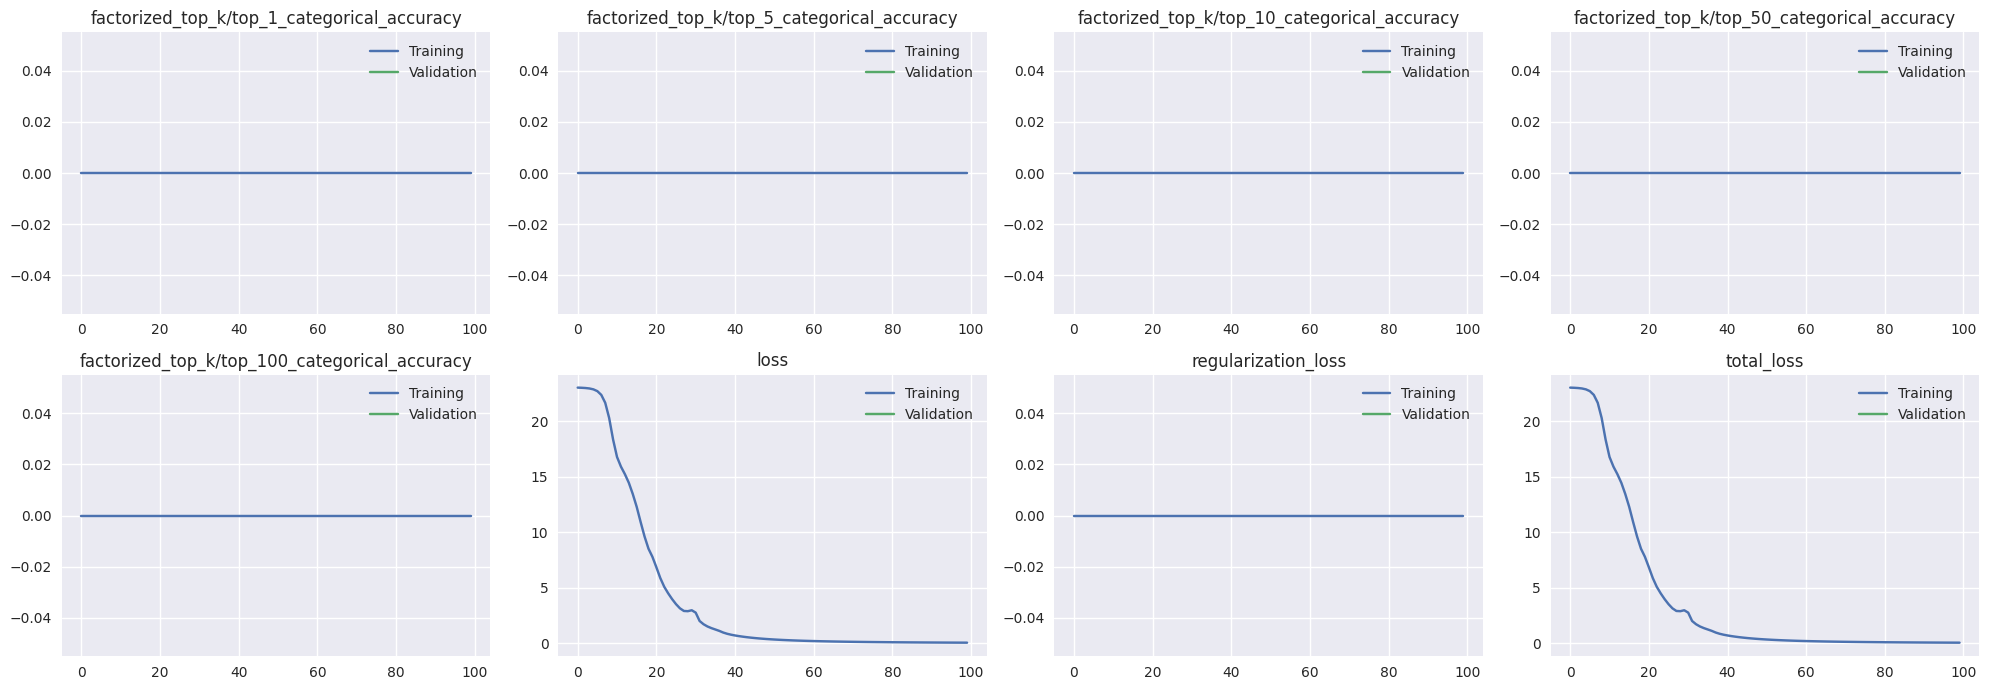

In [14]:
plot_history(history = history)

In [15]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    retrieval_model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          candidates_corpus_dataset.batch(100).map(retrieval_model.candidate_tower)
      )
  )
)

user_id = '41'
afinity_scores, movie_ids = scann_layer(
    {
        'user_id': tf.convert_to_tensor([user_id])
    }
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]} (Confidences: {afinity_scores[0, :5]})")

Recommendations for user 41 using ScaNN: [b'975' b'591' b'898' b'313' b'123'] (Confidences: [1.4078867  1.2409731  1.2409731  0.7479445  0.68394595])


2024-08-28 19:32:07.789253: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-28 19:32:07.829312: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-08-28 19:32:07.842164: W scann/utils/gmm_utils.cc:920] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-08-28 19:32:07.845666: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 16.288654ms.
